In [1]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
from torch import nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch

In [3]:
from augmentation import augment_image

In [4]:
X = np.load('data/merged_selected_nparray.npy')
y = np.load('data/labels_nparray.npy')

In [5]:
X_tensor = torch.from_numpy(X).float().permute(0, 3, 1, 2)
y_tensor = torch.tensor(y, dtype=torch.long)
y_tensor = torch.argmax(y_tensor, dim=1)

In [6]:
class_counts = torch.bincount(y_tensor) # Creates a vector with counts of data for each class
minority_classes = torch.where(class_counts < 2000)[0]

minority_indices = torch.cat([torch.where(y_tensor == cls)[0] for cls in minority_classes])

minority_data = X_tensor[minority_indices]
minority_labels = y_tensor[minority_indices]


In [7]:
augmented_data = []
augmented_labels = []

for i, image in enumerate(minority_data):
    
    for _ in range(6):  # Generate 4 augmented images per sample
        augmented_image = augment_image(image.numpy())  # Convert tensor to numpy for processing
        augmented_data.append(augmented_image)
        augmented_labels.append(minority_labels[i].item())  # Append the same label

# Convert back to tensors
augmented_data = torch.tensor(augmented_data, dtype=torch.float32)
augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

# Combine augmented data with original dataset
X_augmented = torch.cat((X_tensor, augmented_data), dim=0)
y_augmented = torch.cat((y_tensor, augmented_labels), dim=0)

print(f"New dataset size: {X_augmented.shape}, {y_augmented.shape}")

New dataset size: torch.Size([111657, 6, 11, 11]), torch.Size([111657])


C:\Users\matte\AppData\Local\Temp\ipykernel_24596\1175609557.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  augmented_data = torch.tensor(augmented_data, dtype=torch.float32)


In [8]:
num_classes = y_augmented.max().item() + 1  # Determine the number of classes (C)
y_tensor_one_hot = torch.nn.functional.one_hot(y_augmented, num_classes=num_classes)

In [9]:
number_samples = X.shape[0]
X_num = X_augmented.numpy()
y_num = y_augmented.numpy()

X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, test_size=0.2, random_state=24, shuffle=True)

In [10]:
X_tensor_t = torch.from_numpy(X_train).float()
y_tensor_t = torch.from_numpy(y_train).long()

In [11]:
dataset = TensorDataset(X_tensor_t, y_tensor_t)

# Crea un DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
class CustomResNet(nn.Module):
    def __init__(self, num_bands=6, num_classes=19):
        super(CustomResNet, self).__init__()
        
        # Load a pretrained ResNet (e.g., ResNet18)
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze all the pretrained ResNet weights
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Add a new convolutional layer at the beginning
        self.input_conv = nn.Conv2d(
            in_channels=num_bands,  # Input bands (6 in your case)
            out_channels=3,        # Output channels to match ResNet input
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features  # Number of features in ResNet's fc layer
        self.resnet.fc = nn.Linear(num_features, num_classes)  # Output 19 classes
        
    def forward(self, x):
        # Pass through the custom input layer
        x = self.input_conv(x)
        x = self.resnet(x)  # Pass through the ResNet
        return x

In [13]:
# Create an instance of the model
model = CustomResNet(num_bands=6, num_classes=19)

# Print the model summary (optional)
print(model)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # Trainable parameters only
    lr=1e-4
)

# Check trainable parameters
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

C:\Users\matte\.conda\envs\dseo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\matte\.conda\envs\dseo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloader:  # Replace train_loader with your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 2.7221
Epoch 2/10, Loss: 2.2706
Epoch 3/10, Loss: 2.3857
Epoch 4/10, Loss: 2.7255
Epoch 5/10, Loss: 2.2660
Epoch 6/10, Loss: 2.5815
Epoch 7/10, Loss: 2.6955
Epoch 8/10, Loss: 2.2379
Epoch 9/10, Loss: 2.3496
Epoch 10/10, Loss: 2.3765


In [15]:
model.eval()

X_torch = torch.from_numpy(X_test)

y_pred = model(X_torch)

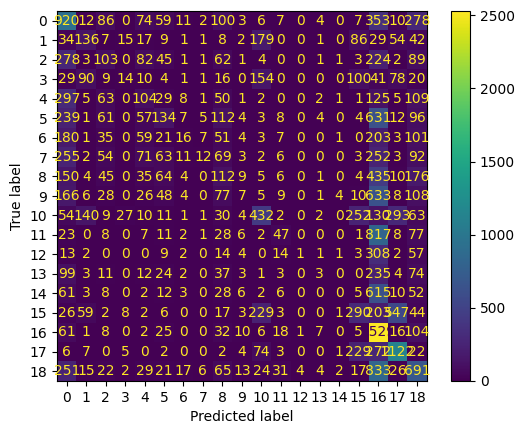

Accuracy ResNet18 weigthed:  0.29880888411248435


In [16]:
y_pred_np = y_pred.detach().cpu().numpy()
y_pred_labels = np.argmax(y_pred_np, axis=1)

#y_test_np = np.argmax(y_test, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels)
plt.show()

acc = accuracy_score(y_test, y_pred_labels)
print("Accuracy ResNet18 weigthed: ", acc)

(array([ 9297.,  3185.,  4518.,  2569.,  4190.,  7085.,  3435.,  4484.,
         5289.,  5785.,  7203.,  5136.,  2090.,  2494.,  4078.,  7644.,
        14178.,  8813., 10184.]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]),
 <BarContainer object of 19 artists>)

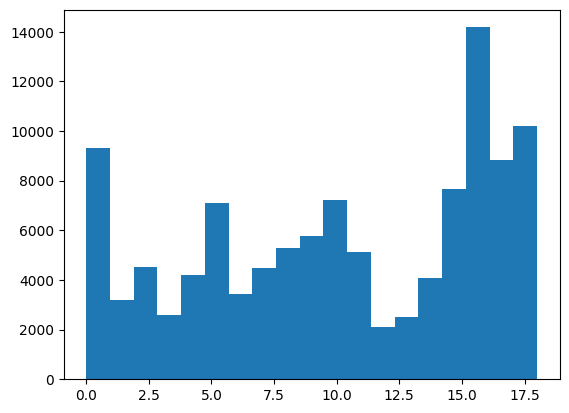

In [17]:
plt.hist(np.argmax(y_tensor_one_hot.numpy(), axis=1), bins = 19)